In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math
import itertools

# Modelling Helpers :
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score



# Evaluation metrics :

# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score


# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical


# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns


# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [4]:
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommender System/ratings.csv')
movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommender System/movies.csv')
df_r = ratings.copy()
df_m = movies.copy()

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
ratings.shape

(100836, 4)

In [7]:
ratings.drop(['timestamp'], axis=1, inplace=True)

In [8]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [9]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [10]:
df_combined = pd.merge(ratings, movies, on = 'movieId')

In [11]:
df_combined.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [12]:
genres = {} # create a dictionary to store different genre values

def find_genres():
    for genre in movies['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1

find_genres()

In [13]:
genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [14]:
genres['None'] = genres.pop('(no genres listed)')

In [15]:
#pip install wordcloud

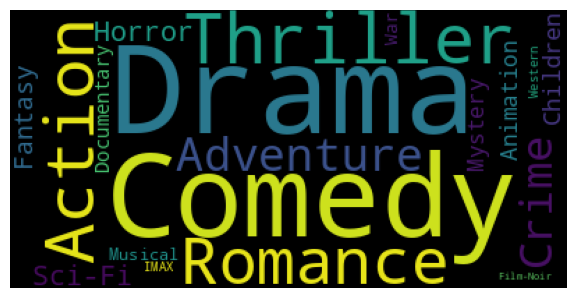

In [16]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=400, height=200, background_color = 'black', min_font_size=7).generate_from_frequencies(genres)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [17]:
#heavily rated movies

df_n_ratings = pd.DataFrame(df_combined.groupby('title')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(df_combined.groupby('title')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


<ipython-input-18-bea5023d69ce>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_n_ratings['total ratings'], bins=20)


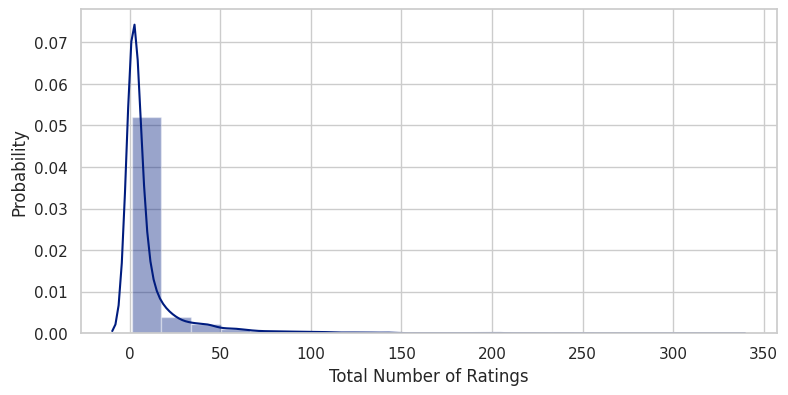

In [18]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

In [19]:
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
"Match Factory Girl, The (Tulitikkutehtaan tyttö) (1990)",5.0,1
Meantime (1984),5.0,1
"Decalogue, The (Dekalog) (1989)",5.0,1
"Stand, The (1994)",5.0,1
Big Top Scooby-Doo! (2012),5.0,1
I Am Not Your Negro (2017),5.0,1
Trinity and Sartana Are Coming (1972),5.0,1
Trailer Park Boys (1999),5.0,1
Bitter Lake (2015),5.0,1


<ipython-input-20-5a4d51eaed91>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_n_ratings['mean ratings'], bins=30)


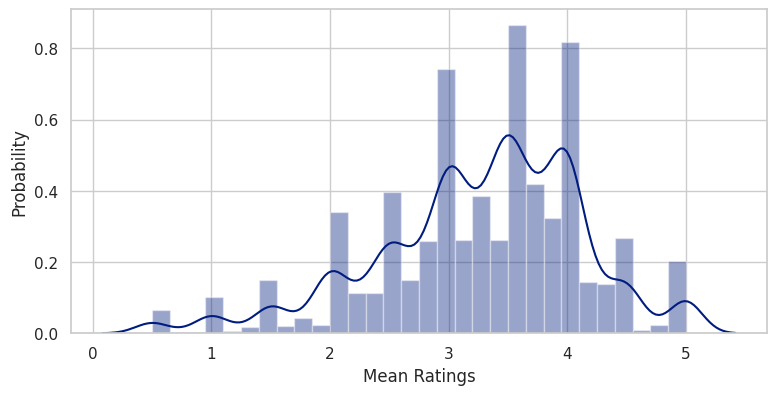

In [20]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['mean ratings'], bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

In [21]:
util_mat = df_combined.pivot_table(index = 'userId', columns = 'title', values = 'rating')
util_mat.head(20)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [22]:
user_util_matrix = util_mat.copy()

# We will fill the row wise NaN's with the corresponding user's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the movie that is not rated.
user_util_matrix = user_util_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,...,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.000000,4.366379
2,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,...,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276
3,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,...,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897
4,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556
5,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,...,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364


In [23]:
user_util_matrix.T.corr()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.264516e-03,5.525772e-04,0.048419,0.021847,-0.045497,-6.199672e-03,0.047013,1.950985e-02,-8.754088e-03,...,0.018127,-0.017172,-0.015221,-3.705875e-02,-2.912138e-02,0.012016,0.055261,0.075224,-2.571255e-02,0.010932
2,0.001265,1.000000e+00,-4.975816e-17,-0.017164,0.021796,-0.021051,-1.111357e-02,-0.048085,7.652805e-16,3.011629e-03,...,-0.050551,-0.031581,-0.001688,-1.265569e-15,-6.430371e-16,0.006226,-0.020504,-0.006001,-6.009100e-02,0.024999
3,0.000553,-4.975816e-17,1.000000e+00,-0.011260,-0.031539,0.004800,-2.587070e-16,-0.032471,-4.812885e-16,3.774064e-16,...,-0.004904,-0.016117,0.017749,-8.106536e-16,-1.430628e-03,-0.037289,-0.007789,-0.013001,-1.168878e-16,0.019550
4,0.048419,-1.716402e-02,-1.125978e-02,1.000000,-0.029620,0.013956,5.809139e-02,0.002065,-5.873603e-03,5.159032e-02,...,-0.037687,0.063122,0.027640,-1.378212e-02,4.003747e-02,0.020590,0.014628,-0.037569,-1.788358e-02,-0.000995
5,0.021847,2.179571e-02,-3.153892e-02,-0.029620,1.000000,0.009111,1.011715e-02,-0.012284,7.750436e-16,-3.316512e-02,...,0.015964,0.012427,0.027076,1.246135e-02,-3.627206e-02,0.026319,0.031896,-0.001751,9.382892e-02,-0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.012016,6.225827e-03,-3.728895e-02,0.020590,0.026319,-0.009137,2.832591e-02,0.022277,3.163273e-02,-3.994577e-02,...,0.053683,0.016384,0.098011,6.107833e-02,1.967830e-02,1.000000,0.017927,0.056676,3.842210e-02,0.075464
607,0.055261,-2.050374e-02,-7.789105e-03,0.014628,0.031896,0.045501,3.098070e-02,0.048822,-1.216061e-02,-1.765576e-02,...,0.049059,0.038197,0.049317,2.355180e-03,-2.938114e-02,0.017927,1.000000,0.044514,1.904919e-02,0.021860
608,0.075224,-6.000828e-03,-1.300064e-02,-0.037569,-0.001751,0.021727,2.841409e-02,0.071759,3.278284e-02,-5.199963e-02,...,0.069198,0.051388,0.012801,6.318649e-03,-7.977761e-03,0.056676,0.044514,1.000000,5.071449e-02,0.054454


In [24]:
user_corr_mat = user_util_matrix.T.corr()
corr_user_1 = user_corr_mat.iloc[0]

In [25]:
corr_user_1.sort_values(ascending=False, inplace=True)

In [26]:
corr_user_1

,1
userId,
1,1.000000
301,0.124799
597,0.102631
414,0.101348
477,0.099217
...,...
71,-0.082932
370,-0.086678
501,-0.090018


In [27]:
# NaN values are generated in corr() as the std dev is zero, which is required in calculating Pearson Similarity.
corr_user_1.dropna(inplace = True)

In [28]:
# Neglect the 1st corr value as it is user1 itself
top50_corr_users = corr_user_1[1:51]

In [29]:
df_combined[ df_combined['userId'] == 1]

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
227,1,3744,4.0,Shaft (2000),Action|Crime|Thriller
228,1,3793,5.0,X-Men (2000),Action|Adventure|Sci-Fi
229,1,3809,4.0,What About Bob? (1991),Comedy
230,1,4006,4.0,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [30]:
# user1 has not rated 32 movie
df_combined[ (df_combined['userId'] == 1) & (df_combined['movieId'] == 32) ]

,userId,movieId,rating,title,genres


In [31]:
print('32nd Movie : ', movies['title'][ movies['movieId'] == 32 ].values)

32nd Movie :  ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']


In [32]:
df_n_ratings.loc[['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']]

,mean ratings,total ratings
title,,
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.983051,177


In [33]:
top50_users = top50_corr_users.keys()

count = 0
users = list()
for user in top50_users:
    if df_combined[ (df_combined['userId'] == user) & (df_combined['movieId'] == 32) ]['rating'].sum()  :
        count +=1
        users.append(user)

print(count)

30


There are 30 similar users among the Top-50 similar users that have rated the movie "The Twelve Monkeys".

Now, let's calculate the rating user 1 would give to the movie,

Predicted rating = sum of [ (weights) * (ratings) ] / sum of (weights)

Here, weights is the correlation of the corresponding user with the first user.

In [34]:
def predict_rating():
    sum_similarity = 0
    weighted_ratings = 0
    for user in users:
        weighted_ratings += top50_corr_users.loc[user] * df_combined[ (df_combined['userId'] == user) &
                                                              (df_combined['movieId'] == 32) ]['rating'].sum()
        sum_similarity += top50_corr_users.loc[user]

    print(weighted_ratings / sum_similarity)


predict_rating()

4.1368953015974315


In [35]:
df_m[ df_m['movieId'] == 32]

,movieId,title,genres
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller


Well there are pretty good changes of recommending this movie movie to the 1st user, since the rating is quite good.

So, this is how a naive User-based CF works. Predicted ratings are calculated similarly for every user, (obviously for the movies he's not rated) and depending upon the threshold rating, the movie is either displayed on his recommended list or discarded.

# 2) Item Based Collaborative Filtering

In [36]:
# Let's find similar movies to jurassic Park
df_n_ratings.loc[['Jurassic Park (1993)']]

,mean ratings,total ratings
title,,
Jurassic Park (1993),3.75,238


In [37]:
item_util_matrix = util_mat.copy()
item_util_matrix.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [38]:
item_util_matrix = item_util_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)
item_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,4.000000,1.0
2,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
3,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
4,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
5,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0


In [39]:
item_util_matrix.isna().sum().sum()

0

This signifies that every Movie is rated by atleast 1 user.

In [40]:
item_util_matrix.corr()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,1.000000e+00,NaN,-2.470228e-17,NaN,-6.783236e-16,-4.090781e-16,...,NaN,1.491400e-15,-2.970631e-18,NaN,NaN,-1.174172e-16,-4.643126e-16,-1.457468e-15,2.901144e-15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,-1.174172e-16,NaN,6.069910e-02,NaN,-7.527708e-02,2.947366e-02,...,NaN,-1.447002e-15,-3.196632e-16,NaN,NaN,1.000000e+00,3.784587e-02,1.243849e-15,-3.410933e-02,NaN
xXx (2002),NaN,NaN,NaN,NaN,-4.643126e-16,NaN,-3.527098e-03,NaN,1.558884e-01,2.511177e-01,...,NaN,-2.067568e-01,-4.854206e-03,NaN,NaN,3.784587e-02,1.000000e+00,2.449296e-01,1.854832e-02,NaN
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,-1.457468e-15,NaN,6.027298e-16,NaN,1.107823e-01,-1.311693e-15,...,NaN,-2.014024e-01,7.715167e-02,NaN,NaN,1.243849e-15,2.449296e-01,1.000000e+00,1.034849e-15,NaN


In [41]:
item_corr_matrix = item_util_matrix.corr()

In [42]:
movie_corr = item_corr_matrix['Jurassic Park (1993)']
movie_corr = movie_corr.sort_values(ascending=False)
movie_corr.dropna(inplace=True)

In [43]:
movies_similar_to_selected_movie = pd.DataFrame(data=movie_corr.values, columns=['Correlation'], index = movie_corr.index)
movies_similar_to_selected_movie = movies_similar_to_selected_movie.join(df_n_ratings['total ratings'])
movies_similar_to_selected_movie.head(10)

,Correlation,total ratings
title,,
Jurassic Park (1993),1.000000,238
"Fugitive, The (1993)",0.324717,190
Lethal Weapon (1987),0.318646,75
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Mulan (1998),0.255672,45
Rise of the Planet of the Apes (2011),0.248134,27
"Bug's Life, A (1998)",0.240964,92


In [44]:
movies_similar_to_selected_movie =movies_similar_to_selected_movie[1:]
movies_similar_to_selected_movie[ movies_similar_to_selected_movie['total ratings'] > 100 ].sort_values(ascending=False,
                                                                                          by=['Correlation']).head(10)

,Correlation,total ratings
title,,
"Fugitive, The (1993)",0.324717,190
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Indiana Jones and the Temple of Doom (1984),0.239826,108
Die Hard (1988),0.239294,145
Aladdin (1992),0.227711,183
Braveheart (1995),0.222085,237
Speed (1994),0.220720,171


# Model based CF

In [45]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357291 sha256=6d1cadf90abed5d84c2ff01876b1dd8cd1fafb3536648c7eb22f7d5cc604d9b6
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [46]:
from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate

In [47]:
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df( ratings[['userId', 'movieId', 'rating']], reader = reader )

# 1) K-Nearest Neighbours (KNN)

In [48]:
sim_options = {'name' : 'msd'}

algo = KNNBasic(k=20, sim_options=sim_options )
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9430  0.9384  0.9479  0.9367  0.9416  0.9415  0.0039  
Fit time          0.08    0.10    0.31    0.20    0.15    0.17    0.08    
Test time         1.44    3.15    3.23    2.04    2.54    2.48    0.68    


{'test_rmse': array([0.9429634 , 0.93842687, 0.94785973, 0.93671314, 0.94156245]),
 'fit_time': (0.07784605026245117,
  0.10130834579467773,
  0.3099691867828369,
  0.1988825798034668,
  0.15022730827331543),
 'test_time': (1.4381558895111084,
  3.1511504650115967,
  3.2261736392974854,
  2.03816556930542,
  2.536540985107422)}

In [49]:
n_neighbours = [10, 20, 30]
param_grid = {'n_neighbours' : n_neighbours}

gs = GridSearchCV(KNNBasic, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

# 2. Singular Value Decomposition (SVD)

In [50]:
algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8687  0.8786  0.8684  0.8748  0.8765  0.8734  0.0041  
Fit time          1.03    0.99    1.60    1.57    1.01    1.24    0.28    
Test time         0.09    0.09    0.16    0.30    0.09    0.14    0.08    


{'test_rmse': array([0.86873673, 0.87859607, 0.8684206 , 0.87477999, 0.87653643]),
 'fit_time': (1.034148931503296,
  0.9929628372192383,
  1.6023147106170654,
  1.570298671722412,
  1.0076475143432617),
 'test_time': (0.08690810203552246,
  0.08722758293151855,
  0.15509939193725586,
  0.30416035652160645,
  0.09072303771972656)}

In [51]:
param_grid = {'n_factors' : [50, 75], 'lr_all' : [0.5, 0.05], 'reg_all' : [0.06, 0.04]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')


###############
Best Score : 0.863567373649774
Best Parameters : {'n_factors': 75, 'lr_all': 0.05, 'reg_all': 0.06}
###############


# 3. Non-Negative Matrix Factorization (NMF)

In [52]:
algo = NMF()
cross_validate(data=data, algo=algo, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9254  0.9249  0.9133  0.9204  0.9342  0.9237  0.0068  
Fit time          1.73    1.84    1.88    1.98    1.94    1.87    0.09    
Test time         0.09    0.09    0.08    0.08    0.13    0.09    0.02    


{'test_rmse': array([0.92538576, 0.9248746 , 0.91333588, 0.9204174 , 0.93423849]),
 'fit_time': (1.7272238731384277,
  1.8415846824645996,
  1.884812593460083,
  1.984461784362793,
  1.9359045028686523),
 'test_time': (0.08537745475769043,
  0.08866119384765625,
  0.07580232620239258,
  0.07552957534790039,
  0.13225603103637695)}

# 4. Matrix Factorization using Deep Learning (Keras)

In [53]:
from keras.layers import Embedding, Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot

In [54]:
X = ratings.iloc[:,:2]
Y = ratings.iloc[:,2]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)

# The number of latent factors for the embedding
n_latent_factors = 50

# no of users and movies
n_users, n_movies = len(ratings['userId'].unique()), len(ratings['movieId'].unique())

# Model 1

In [55]:
# del model1

In [56]:
# Model Architecture


# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1,
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1, name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)


# Dot Product
merged_vectors = dot([user_vector, movie_vector], name='Dot_Product', axes=1)
model1 = Model([user_input, movie_input], merged_vectors)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Model skeleton

In [57]:
# SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [58]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image

# # Save the model plot as a PNG file
# plot_model(model1, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=200)

# # Display the PNG image
# Image('model.png')


In [59]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ User_Input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Embedding            │ (None, 1, 50)          │         30,500 │ User_Input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Embedding           │ (None, 1, 50)          │        486,200 │ Movie_Input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Vector (Flatten)     │ (None, 50)             │              0 │ User_Embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Vector (Flatten)    │ (None, 50)             │              0 │ Movie_Embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Dot_Product (Dot)         │ (None, 1)              │              0 │ User_Vector[0][0],     │
│                           │                        │                │ Movie_Vector[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 516,700 (1.97 MB)

 Trainable params: 516,700 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

# Compiling the Model

In [60]:
from tensorflow.keras.optimizers import Adam

# Create the optimizer with the correct parameter name
optimizer = Adam(learning_rate=0.0006)

# Compile the model
model1.compile(loss='mean_squared_error', optimizer=optimizer)


# Fitting the Model

In [61]:
batch_size = 128
epochs = 30

In [62]:
history = model1.fit(
    x=[x_train['userId'], x_train['movieId']],
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=([x_test['userId'], x_test['movieId']], y_test),
)


Epoch 1/30
631/631 - 3s - 5ms/step - loss: 12.6924 - val_loss: 10.3897
Epoch 2/30
631/631 - 1s - 2ms/step - loss: 6.9763 - val_loss: 4.8222
Epoch 3/30
631/631 - 1s - 2ms/step - loss: 4.0970 - val_loss: 3.6814
Epoch 4/30
631/631 - 1s - 1ms/step - loss: 3.3328 - val_loss: 3.2193
Epoch 5/30
631/631 - 1s - 2ms/step - loss: 2.9686 - val_loss: 2.9621
Epoch 6/30
631/631 - 1s - 2ms/step - loss: 2.7450 - val_loss: 2.7863
Epoch 7/30
631/631 - 1s - 2ms/step - loss: 2.5808 - val_loss: 2.6574
Epoch 8/30
631/631 - 2s - 3ms/step - loss: 2.4499 - val_loss: 2.5530
Epoch 9/30
631/631 - 2s - 3ms/step - loss: 2.3392 - val_loss: 2.4674
Epoch 10/30
631/631 - 1s - 2ms/step - loss: 2.2392 - val_loss: 2.3870
Epoch 11/30
631/631 - 1s - 2ms/step - loss: 2.1467 - val_loss: 2.3102
Epoch 12/30
631/631 - 1s - 2ms/step - loss: 2.0583 - val_loss: 2.2418
Epoch 13/30
631/631 - 1s - 2ms/step - loss: 1.9730 - val_loss: 2.1763
Epoch 14/30
631/631 - 1s - 2ms/step - loss: 1.8896 - val_loss: 2.1126
Epoch 15/30
631/631 - 1s - 

# Displaying the Validation and Training Loss

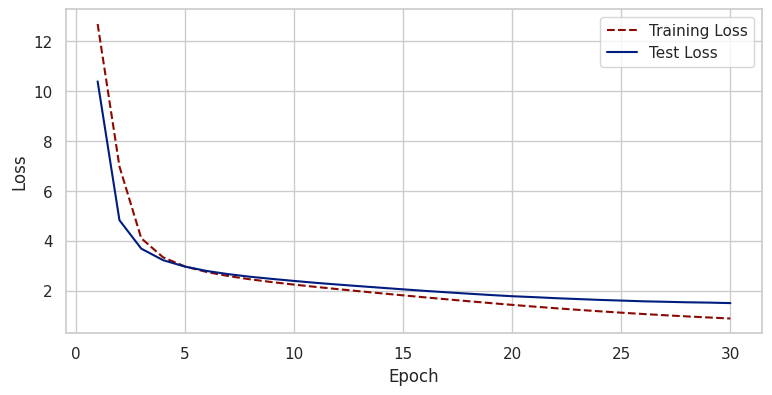

In [63]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluating RMSE

In [64]:
score = model1.evaluate([x_test['userId'], x_test['movieId']], y_test)
print()
print('RMSE: {:.4f}'.format(np.sqrt(score)))

631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4941

RMSE: 1.2237


# Model 2

In [65]:
# del model2

In [66]:
#Model Architecture


# User Embeddings
user_input = Input(shape=(1,), name='User_Input')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)



# Movie Embeddings
movie_input = Input(shape=(1,), name='Movie_Input')
movie_embeddings = Embedding(input_dim = n_movies, output_dim=n_latent_factors, input_length=1,name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)


# Concatenate Product
merged_vectors = concatenate([user_vector, movie_vector], name='Concantenate')
dense_layer_1 = Dense(100, activation='relu')(merged_vectors)





result = Dense(1)(dense_layer_1)

model2 = Model([user_input, movie_input], result)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [67]:
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ User_Input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Embedding            │ (None, 1, 50)          │         30,500 │ User_Input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Embedding           │ (None, 1, 50)          │        486,200 │ Movie_Input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ User_Vector (Flatten)     │ (None, 50)             │              0 │ User_Embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Movie_Vector (Flatten)    │ (None, 50)             │              0 │ Movie_Embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Concantenate              │ (None, 100)            │              0 │ User_Vector[0][0],     │
│ (Concatenate)             │                        │                │ Movie_Vector[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 100)            │         10,100 │ Concantenate[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            101 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 526,901 (2.01 MB)

 Trainable params: 526,901 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image

# # Save the model plot as a PNG file
# plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True, dpi=200)

# # Display the PNG image
# Image('model.png')


In [69]:
from keras.callbacks import ReduceLROnPlateau


optimizer = Adam(learning_rate=0.0002)
model2.compile(loss='mean_squared_error', optimizer=optimizer)
batch_size = 128
epochs = 20


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)


In [70]:
history = model2.fit(
    x=[x_train['userId'], x_train['movieId']],
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_split=0.2,  # Use 20% of data for validation
    callbacks=[reduce_lr]
)


Epoch 1/20
505/505 - 3s - 7ms/step - loss: 5.1105 - val_loss: 1.0104 - learning_rate: 2.0000e-04
Epoch 2/20
505/505 - 4s - 8ms/step - loss: 0.8645 - val_loss: 0.8177 - learning_rate: 2.0000e-04
Epoch 3/20
505/505 - 2s - 4ms/step - loss: 0.7603 - val_loss: 0.7910 - learning_rate: 2.0000e-04
Epoch 4/20
505/505 - 1s - 2ms/step - loss: 0.7332 - val_loss: 0.7864 - learning_rate: 2.0000e-04
Epoch 5/20
505/505 - 1s - 3ms/step - loss: 0.7215 - val_loss: 0.7855 - learning_rate: 2.0000e-04
Epoch 6/20
505/505 - 1s - 2ms/step - loss: 0.7158 - val_loss: 0.7881 - learning_rate: 2.0000e-04
Epoch 7/20
505/505 - 1s - 2ms/step - loss: 0.7125 - val_loss: 0.7867 - learning_rate: 2.0000e-04
Epoch 8/20

Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
505/505 - 1s - 2ms/step - loss: 0.7091 - val_loss: 0.7910 - learning_rate: 2.0000e-04
Epoch 9/20
505/505 - 1s - 2ms/step - loss: 0.6946 - val_loss: 0.7896 - learning_rate: 1.0000e-04
Epoch 10/20
505/505 - 1s - 3ms/step - loss: 0.6935

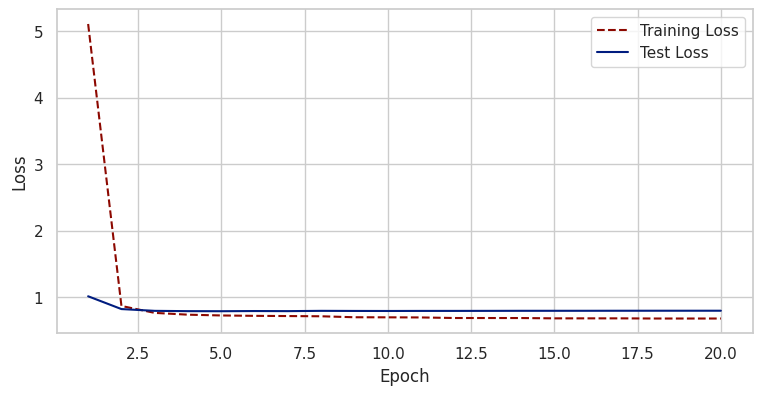

In [71]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [72]:
score = model2.evaluate([x_test['userId'], x_test['movieId']], y_test)

print()
print('RMSE: {:.4f}'.format(np.sqrt(score)))

631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8017

RMSE: 0.8936


In [73]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

movie_lookup = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Recommender System/movies.csv')

# Function to extract movie embeddings from model2
def get_movie_embeddings(model, movie_id_input_dim):
    for layer in model.layers:
        if 'embedding' in layer.name.lower() and 'movie' in layer.name.lower():
            movie_embedding_layer = layer
            break
    else:
        raise ValueError("No movie embedding layer found in the model.")


    movie_ids = np.arange(movie_id_input_dim)


    movie_embeddings = movie_embedding_layer(movie_ids).numpy()
    return movie_embeddings

# Function to find similar movies
def find_similar_movies(movie_id, movie_embeddings, top_n=5):
    if movie_id >= movie_embeddings.shape[0]:
        raise ValueError("Invalid movie_id. It exceeds the embedding matrix size.")

    # Get embedding for the given movie
    target_embedding = movie_embeddings[movie_id].reshape(1, -1)

    # Compute cosine similarity
    similarities = cosine_similarity(target_embedding, movie_embeddings)[0]

    # Get top-N similar movies (excluding the given movie itself)
    similar_movie_indices = similarities.argsort()[-top_n - 1:][::-1]
    similar_movies = [(i, similarities[i]) for i in similar_movie_indices if i != movie_id][:top_n]

    return similar_movies

# Function to print similar movies with names
def print_similar_movies(movie_id, similar_movies, movie_lookup):
    input_movie_title = movie_lookup.loc[movie_lookup['movieId'] == movie_id, 'title'].values[0]
    print(f"Movies similar to '{input_movie_title}':\n")

    for similar_movie_id, score in similar_movies:
        title = movie_lookup.loc[movie_lookup['movieId'] == similar_movie_id, 'title'].values[0]
        print(f"- {title} (Similarity: {score:.2f})")


In [74]:
movie_id_input_dim = len(movie_lookup)
movie_embeddings = get_movie_embeddings(model2, movie_id_input_dim)
given_movie_id = movie_lookup.loc[movie_lookup['title'] == "Terminator 2: Judgment Day (1991)", 'movieId'].values[0]
similar_movies = find_similar_movies(given_movie_id, movie_embeddings, top_n=10)
print_similar_movies(given_movie_id, similar_movies, movie_lookup)


Movies similar to 'Terminator 2: Judgment Day (1991)':

- Lagaan: Once Upon a Time in India (2001) (Similarity: 0.65)
- Blow-Out (La grande bouffe) (1973) (Similarity: 0.65)
- Code 46 (2003) (Similarity: 0.65)
- Awful Truth, The (1937) (Similarity: 0.65)
- Rope (1948) (Similarity: 0.64)
- Remember the Titans (2000) (Similarity: 0.63)
- Outsiders, The (1983) (Similarity: 0.63)
- Best Years of Our Lives, The (1946) (Similarity: 0.63)
- Cruise, The (1998) (Similarity: 0.63)
- Paid in Full (2002) (Similarity: 0.63)


In [75]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.5 MB/s eta 0:00:00


In [76]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display

# Function to extract movie embeddings from model2
def get_movie_embeddings(model, movie_id_input_dim):
    for layer in model.layers:
        if 'embedding' in layer.name.lower() and 'movie' in layer.name.lower():
            movie_embedding_layer = layer
            break
    else:
        raise ValueError("No movie embedding layer found in the model.")

    movie_ids = np.arange(movie_id_input_dim)
    movie_embeddings = movie_embedding_layer(movie_ids).numpy()
    return movie_embeddings

# Function to find similar movies
def find_similar_movies(movie_id, movie_embeddings, top_n=5):
    if movie_id >= movie_embeddings.shape[0]:
        raise ValueError("Invalid movie_id. It exceeds the embedding matrix size.")

    target_embedding = movie_embeddings[movie_id].reshape(1, -1)
    similarities = cosine_similarity(target_embedding, movie_embeddings)[0]

    similar_movie_indices = similarities.argsort()[-top_n - 1:][::-1]
    similar_movies = [(i, similarities[i]) for i in similar_movie_indices if i != movie_id][:top_n]

    return similar_movies

# Function to print similar movies with names
def print_similar_movies(movie_id, similar_movies, movie_lookup):
    input_movie_title = movie_lookup.loc[movie_lookup['movieId'] == movie_id, 'title'].values[0]
    similar_movies_list = []

    for similar_movie_id, score in similar_movies:
        title = movie_lookup.loc[movie_lookup['movieId'] == similar_movie_id, 'title'].values[0]
        similar_movies_list.append(f"{title} (Similarity: {score:.2f})")

    return f"Movies similar to '{input_movie_title}':\n" + "\n".join(similar_movies_list)

# Sort movie titles in ascending order
movie_lookup = movie_lookup.sort_values(by='title')

movie_id_input_dim = len(movie_lookup)
movie_embeddings = get_movie_embeddings(model2, movie_id_input_dim)

# Create a dropdown for movie title input (sorted alphabetically)
movie_title_widget = widgets.Dropdown(
    options=movie_lookup['title'].tolist(),
    description='Movie:',
    disabled=False
)

# Output widget for displaying recommendations
output = widgets.Output()

# Define function to handle the movie selection and display recommendations
def on_movie_select(change):
    with output:
        output.clear_output()
        movie_title_input = change.new
        try:
            given_movie_id = movie_lookup.loc[movie_lookup['title'] == movie_title_input, 'movieId'].values[0]
            similar_movies = find_similar_movies(given_movie_id, movie_embeddings, top_n=10)
            recommendations = print_similar_movies(given_movie_id, similar_movies, movie_lookup)
            print(recommendations)
        except KeyError:
            print("Movie not found. Please try again.")

# Link the dropdown widget to the function
movie_title_widget.observe(on_movie_select, names='value')

# Display the UI components
display(movie_title_widget, output)


Dropdown(description='Movie:', options=("'71 (2014)", "'Hellboy': The Seeds of Creation (2004)", "'Round Midni…

Output()